## Importing the packages

In [1]:
import cv2
from os import path
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

#accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
#!pip install Pillow==4.0.0
#!pip install image
%matplotlib inline

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
import h5py

/Users/isa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/isa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/isa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/isa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/isa/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from num

## The Start

In [4]:
PATH = "data/"
sz=224
torch.cuda.is_available()

False

In [10]:
torch.backends.cudnn.enabled

True

## List and Display images

In [57]:
import h5py
with h5py.File(PATH+"images_1227.hdf5", "r") as f:
    img=f['images'][...]
    lbl=f['labels'][...]

# Add clever bit of code to filter benign and malignant samples

    

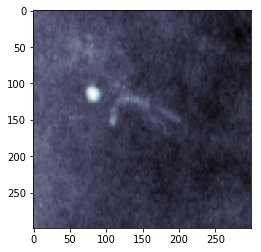

In [22]:
plt.imshow(img[4].reshape((299,299)),cmap=plt.cm.bone)

In [58]:
# Splitting the dataset into equal number of samples for both classes; and then create the validation set
img_b,img_m,=[],[]
for index,label in enumerate(lbl):
    image=img[index]
    if label==b'BENIGN':
        img_b.append(image)
    else:
        img_m.append(image)
img_b=np.array(img_b)
img_m=np.array(img_m)

In [87]:
from utility import *
split=0.8

# Returns train-test split for BENIGN cases 
imgb_trn,imgb_tst=return_trn_test_split(data=img_b,frac=split)
lblb_trn,lblb_tst=return_trn_test_split(data=np.array(['BENIGN']*img_b.shape[0]),frac=split)

# Returns train-test split for MALIGNANT cases  
imgm_trn,imgm_tst=return_trn_test_split(data=img_m,frac=split)
lblm_trn,lblm_tst=return_trn_test_split(data=np.array(['MALIGNANT']*img_m.shape[0]),frac=split)

# Prepare Labels for training set
lbl_trn=np.concatenate([lblb_trn,lblm_trn])

# Prepare Labels for test set
lbl_tst=np.concatenate([lblb_tst,lblm_tst])

# Prepare images for Training set
img_trn=np.vstack([imgb_trn,imgm_trn])

# Prepare images for Test set
img_tst=np.vstack([imgb_tst,imgm_tst])

print('Done!')

Done!


In [90]:
print(lbl_trn.shape,lbl_tst.shape)
print(img_trn.shape,img_tst.shape)

(981,) (246,)
(981, 89401) (246, 89401)


In [91]:
trn,tst=(img_trn,lbl_trn),(img_tst,lbl_tst)

## Initial Model

In [92]:
arch=resnet34
labels=['BENIGN','MALIGNANT']
data = ImageClassifierData.from_arrays(PATH, trn=trn,val=tst,classes=labels,tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
# Find the best learning rate
#lrf=learn.lr_find()

TypeError: cannot perform reduce with flexible type

In [36]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy   
    0      1.873292   203.147704 0.448529  



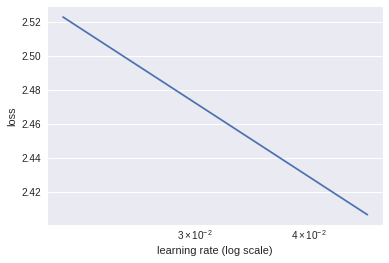

In [37]:
learn.sched.plot()

In [42]:
# Fit once
learn.fit(0.04, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.037718   0.026945   0.988971  



[array([0.02694]), 0.9889705882352942]

In [0]:
learn.precompute=False

In [53]:
# Fit again
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.247841   0.13732    0.974265  
    1      0.250334   0.113909   0.970588  
    2      0.251683   0.097915   0.981618  
    3      0.223784   0.088309   0.977941  
    4      0.19716    0.07805    0.985294  



[array([0.07805]), 0.9852941176470589]

In [0]:
learn.save('224')

## Change size of Image

In [12]:
# Run this only when initialising the model
arch=resnet34
tfms = tfms_from_model(arch, 299, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms,trn_name='training',val_name='validation')
learn = ConvLearner.pretrained(arch, data, precompute=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 97662408.45it/s]


In [0]:
tfms = tfms_from_model(arch, 299, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms,trn_name='training',val_name='validation')
learn.set_data(data)
learn.freeze()

In [56]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.164723   0.092937   0.977941  
    1      0.170718   0.075668   0.985294  
    2      0.164526   0.067321   0.981618  



[array([0.06732]), 0.9816176470588235]

In [57]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy   
    0      0.140643   0.066152   0.977941  
    1      0.152788   0.059445   0.981618  
    2      0.138595   0.057111   0.977941  
    3      0.138765   0.049833   0.985294  
    4      0.130745   0.045633   0.985294  
    5      0.121055   0.045036   0.988971  
    6      0.117725   0.043676   0.988971  



[array([0.04368]), 0.9889705882352942]

In [0]:
learn.save('299')


In [0]:
!mkdir drive/models/monkeys
!cp monkeys/models/* drive/models/monkeys

In [63]:
learn.fit(0.04, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.098369   0.043427   0.988971  
    1      0.093829   0.037283   0.988971  
    2      0.103249   0.035257   0.992647  
    3      0.093968   0.029273   0.992647  
    4      0.095776   0.024333   0.996324  
    5      0.088497   0.024106   0.996324  
    6      0.079947   0.024375   0.996324  



[array([0.02437]), 0.9963235294117647]

In [0]:
learn.save('299_im')
!cp monkeys/models/299_im.h5 drive/models/monkeys

In [14]:
!cp drive/models/monkeys/* monkeys/models/
!ls monkeys/models

224.h5	299.h5	299_im.h5  tmp.h5


In [24]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9926470588235294, 0.024276230360895577)

In [30]:
probs.shape

(272, 10)

In [0]:
learn.load('299_im')
learn.precompute=False
#learn.unfreeze()
#lr=0.04


In [74]:
learn.fit([lr/100,lr/10,lr],1)

epoch      trn_loss   val_loss   accuracy   
    0      0.037509   0.025447   0.988971  


[array([0.02545]), 0.9889705882352942]

## Individual Prediction

In [16]:
data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [32]:
df=pd.read_csv(f'{PATH}monkey_labels.csv',sep=',')
files = os.listdir(f'{PATH}validation/n6')
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


[[-8.47415 -5.3419  -8.98657 -7.33615 -8.40222 -4.85955 -0.01505 -7.9327  -7.99449 -7.61879]]
6    silvery_marmoset
Name: Common Name, dtype: object


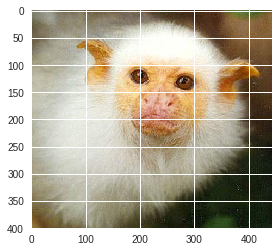

In [33]:
#learn.load('299_im')
img=open_image(f'{PATH}validation/n6/{files[7]}')
plt.imshow(img)
img=tfms[1](img)
preds=learn.predict_array(img[None])
print(preds)
print(df[df.Label==data.classes[np.argmax(preds)]]['Common Name'])

In [35]:
img=plt.imread(f'{PATH}validation/n4/{files[5]}')
print(img.shape)
#img=tfms[1](img)

plt.imshow(img)
#tfms

(550, 700, 3)


In [45]:
fn=f'validation/n4/{files[7]}'
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

4